In [1]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning.pytorch as pl

from lightning.pytorch.tuner import Tuner


In [2]:
# setup data
DATASETS_PATH = os.path.join("..", "..", "datasets")
print('DATASETS_PATH: ', DATASETS_PATH)

dataset = MNIST(DATASETS_PATH, download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

DATASETS_PATH:  ..\..\datasets


In [3]:


# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))


# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder, batch_size=32, learning_rate=0.0001, train_loader=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_loader = train_loader

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def train_dataloader(self):
        return self.train_loader


# init the autoencoder
batch_size = 32
autoencoder = LitAutoEncoder(encoder, decoder, batch_size, train_loader=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


autoencoder.batch_size:  32


Missing logger folder: C:\Users\GyanT\Documents\GitHub\Artificial-Neural-Network\PyTorchLightning\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\GyanT\miniconda3\envs\py3_10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying

autoencoder.batch_size:  65536


`Trainer.fit` stopped: `max_steps=3` reached.
The batch size 65536 is greater or equal than the length of your dataset.
Finished batch size finder, will continue with full run using batch size 65536
Restoring states from the checkpoint path at C:\Users\GyanT\Documents\GitHub\Artificial-Neural-Network\PyTorchLightning\.scale_batch_size_3a77082d-7176-4447-8eaf-cea97d82fef9.ckpt
Restored all states from the checkpoint at C:\Users\GyanT\Documents\GitHub\Artificial-Neural-Network\PyTorchLightning\.scale_batch_size_3a77082d-7176-4447-8eaf-cea97d82fef9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


autoencoder.batch_size:  65536
learning_rate:  0.0001


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 7.585775750291837e-08
Restoring states from the checkpoint path at C:\Users\GyanT\Documents\GitHub\Artificial-Neural-Network\PyTorchLightning\.lr_find_ab8ff999-83ab-4b4e-bfd4-5139a83a9822.ckpt
Restored all states from the checkpoint at C:\Users\GyanT\Documents\GitHub\Artificial-Neural-Network\PyTorchLightning\.lr_find_ab8ff999-83ab-4b4e-bfd4-5139a83a9822.ckpt
C:\Users\GyanT\AppData\Local\Temp\ipykernel_18108\683847612.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 

learning_rate:  7.585775750291837e-08


C:\Users\GyanT\miniconda3\envs\py3_10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


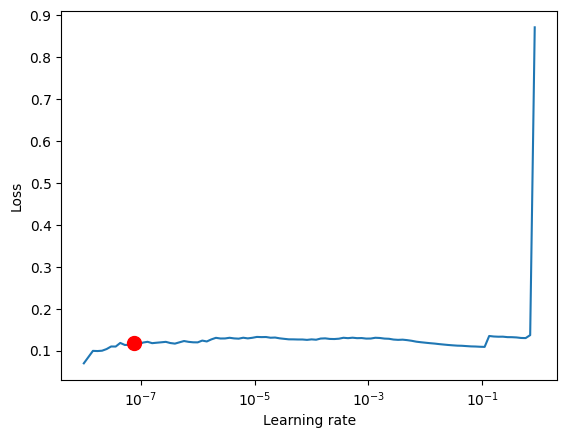

In [4]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# https://lightning.ai/docs/pytorch/stable/common/trainer.html
# https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html

trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
# print('trainer: ', help(trainer))

# Create a tuner for the trainer
tuner = Tuner(trainer)
print('autoencoder.batch_size: ', autoencoder.batch_size)

# Auto-scale batch size by growing it exponentially (default)
tuner.scale_batch_size(model=autoencoder, mode="power")
print('autoencoder.batch_size: ', autoencoder.batch_size)

# Auto-scale batch size with binary search
tuner.scale_batch_size(model=autoencoder, mode="binsearch")
print('autoencoder.batch_size: ', autoencoder.batch_size)

print('learning_rate: ', autoencoder.learning_rate)
# Run learning rate finder
lr_finder = tuner.lr_find(autoencoder)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
autoencoder.hparams.lr = new_lr
print('learning_rate: ', autoencoder.learning_rate)

trainer.fit(model=autoencoder, train_dataloaders=train_loader)

In [5]:
# load checkpoint
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = Tensor(4, 28 * 28).to(device='cuda')
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[ 1.0645e+36,  1.0508e+37, -1.9595e+36],
        [-4.0618e+36,  1.4126e+37,  2.9637e+36],
        [-6.4258e+36,  1.0273e+37, -1.5477e+36],
        [-1.4270e+36,  1.6179e+36, -2.4527e+35]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡
